# Harlowton (1KM) Regression

Compare the observations from the Harlowton, MT AWOS (1KM) 
with the RTMA or NBM 1hr forecast and comute a regression

## Import modules

In [1]:
import xarray            as xr
import pandas            as pd
import numpy             as np
import matplotlib.pyplot as plt
import seaborn           as sns
import scipy.stats       as stats
import os.path 
import pint

## Set some contants

In [2]:
sns.set_theme(color_codes=True)
units = pint.UnitRegistry()
hour = pd.to_timedelta('1H')
normal_distribution = stats.norm()

## Define utility functions

### load_analysis_grid:
Load time series from a gridded source converting units and filtering fields. Also creates the valid time field from reference time and time since reference. Can tranform column names if needed, ie for NBM 1 hour forecast.

In [3]:
def load_analysis_grid(filename, filter_fields=None, transform_columns=None):
    data = xr.open_dataset(filename).to_dataframe()
    if transform_columns is not None:
        data.columns = data.columns.to_series().apply(transform_columns)
    data = data.set_index(data.pop('reference_time') + data.pop('time_since_reference') * hour).sort_index()
    if filter_fields is None:
        filter_fields = data.columns
    return data[filter_fields]

### load_forecast_grid:
Load time series from a gridded source converting units and filtering fields. Also creates the valid time field from reference time and time since reference. Can tranform column names if needed, ie for NBM 1 hour forecast.

In [4]:
def load_forecast_grid(filename, filter_fields=None, transform_columns=None):
    data = xr.open_dataset(filename).to_dataframe()
    if transform_columns is not None:
        data.columns = data.columns.to_series().apply(transform_columns)
    data['valid_time'] = data.reference_time + data.time_since_reference * hour
    data = data.set_index(['reference_time', 'valid_time']).sort_index()
    if filter_fields is None:
        filter_fields = data.columns
    return data[filter_fields]

### filter_missing_data
Filter rows that are filled with NaNs, ignoring time fields by default

In [5]:
def filter_missing_data(data):
    return data.dropna(how='all')

### load_observations
Load time series from observation source, converting units and filtering fields.

In [6]:
def load_observations(filename, filter_fields=None):
    data = xr.open_dataset(filename).to_dataframe().set_index('time').sort_index()
    if filter_fields is not None:
        data = data.loc[:, filter_fields]
    return data

### replace_missing_gust_with_wind
Since that gusts for AWOS/ASOS are not reported unless the gusts is sufficiently higher than sustained wind, replace missing gust values with the sustained to compare to RTMA / NBM that always has a gust value.

In [7]:
def replace_missing_gust_with_wind(data, wind_field, wind_gust_field):
    index = np.isnan(data[wind_gust_field])
    data.loc[index, wind_gust_field] = data[wind_field][index]

### get_period_maximum
Find the maximum values when rounding the time fields to nearest hour

In [8]:
def get_period_maximum(data, period='1H'):
    return data.groupby(data.index.round(period)).max()

### time_match_dataset
Time-match dataset while prefixing the columns of each dataset

In [9]:
def time_match_dataset(left, right, left_prefix='obs', right_prefix='grid', left_time='time', right_time='valid_time'):
    if left_prefix is None:
        left_prefix = ''
    else:
        left_prefix = '_{0:s}'.format(left_prefix)
    if right_prefix is None:
        right_prefix = ''
    else:
        right_prefix = '_{0:s}'.format(right_prefix)
    return pd.merge(left.add_suffix(left_prefix), right.add_suffix(right_prefix), how='inner', left_index=True, right_index=True).sort_index()

### convert_units
Convert units of columns in a DataFrame

In [10]:
def convert_units(data, columns):
    for col in columns.keys():
        data[col] = pint.Quantity(data[col].to_numpy(), units(columns[col][0])).to(units(columns[col][1])).magnitude

### calculate_lower_threshold_speed

Calculate the lower end speed threshold for winds that are relevent to analysis given a criteria threshold and minimum probability

In [11]:
def calculate_lower_threshold_speed(sigma_data, criteria, criteria_units='mph', min_probability=0.005, sigma_threshold=0.95):
    return pint.Quantity(criteria, units(criteria_units)).to(units('m/s')).magnitude - normal_distribution.ppf(1-min_probability) * sigma_data.quantile(sigma_threshold)

## Set Site ID

In [12]:
siteID = '1KM'

## Load RTMA / NBM 1-Hour Forecast Data

In [13]:
analysis = filter_missing_data(load_analysis_grid('../data/nbm_analysis/NBM_{0:s}.nc'.format(siteID), 
                                                  filter_fields=['10_meter_wind_speed', '10_meter_wind_speed_of_gust', '10_meter_wind_from_direction'], 
                                                  transform_columns=lambda a: a.replace('_mean', '')))
analysis = filter_missing_data(analysis)
analysis

,10_meter_wind_speed,10_meter_wind_speed_of_gust,10_meter_wind_from_direction
2020-10-01 00:00:00,6.6,9.600000,10.0
2020-10-01 01:00:00,4.6,8.300000,20.0
2020-10-01 02:00:00,3.9,7.400000,30.0
2020-10-01 03:00:00,3.1,5.400000,330.0
2020-10-01 04:00:00,3.1,4.500000,300.0
...,...,...,...
2021-02-28 19:00:00,12.8,18.700001,270.0
2021-02-28 20:00:00,12.8,18.700001,270.0
2021-02-28 21:00:00,12.8,18.800001,270.0
2021-02-28 22:00:00,12.0,18.400000,280.0


## Load Observation Data

In [14]:
obs =  load_observations('../data/observations/{0:s}.nc'.format(siteID), 
                         filter_fields=['10_meter_wind_speed', '10_meter_wind_speed_of_gust', '10_meter_wind_from_direction'])

replace_missing_gust_with_wind(obs, '10_meter_wind_speed', '10_meter_wind_speed_of_gust')
obs = filter_missing_data(obs)
# obs = obs[obs['10_meter_wind_speed_of_gust'] > (pint.Quantity(20, units('mph')).to(units('m s**-1')).magnitude)]
obs = get_period_maximum(obs, period='1H')
obs

,10_meter_wind_speed,10_meter_wind_speed_of_gust,10_meter_wind_from_direction
time,,,
2020-05-18 01:00:00,0.000000,0.000000,0.0
2020-05-18 02:00:00,4.115556,4.115556,20.0
2020-05-18 03:00:00,2.572222,2.572222,330.0
2020-05-18 04:00:00,2.572222,2.572222,360.0
2020-05-18 05:00:00,2.572222,2.572222,350.0
...,...,...,...
2021-04-17 20:00:00,6.173333,9.260000,20.0
2021-04-17 21:00:00,4.630000,10.803333,40.0
2021-04-17 22:00:00,6.173333,9.774444,30.0


## Load forecast data to calculate analysis threshold

In [15]:
forecast = load_forecast_grid('../data/nbm/NBM_{0:s}.nc'.format(siteID), filter_fields=['10_meter_wind_speed_of_gust_standard_deviation'])
forecast = filter_missing_data(forecast)

## Time-match Observations to RTMA / NBM Analysis
filter using probability threshold

In [16]:
data = time_match_dataset(obs, analysis, right_prefix='analysis')

lower_threshold = calculate_lower_threshold_speed(forecast['10_meter_wind_speed_of_gust_standard_deviation'], 50, criteria_units='mph')
print(pint.Quantity(lower_threshold, units('m s**-1')).to(units('mph')))
data = data[data['10_meter_wind_speed_of_gust_obs'] >= lower_threshold]
data

30.409314876260552 mile_per_hour


,10_meter_wind_speed_obs,10_meter_wind_speed_of_gust_obs,10_meter_wind_from_direction_obs,10_meter_wind_speed_analysis,10_meter_wind_speed_of_gust_analysis,10_meter_wind_from_direction_analysis
2020-10-02 18:00:00,11.317778,15.433333,20.0,6.7,10.200000,350.0
2020-10-02 19:00:00,10.803333,14.918889,360.0,7.8,11.000000,360.0
2020-10-02 20:00:00,10.803333,15.433333,20.0,7.8,11.200000,0.0
2020-10-02 21:00:00,10.803333,14.918889,350.0,7.4,11.000000,10.0
2020-10-02 22:00:00,8.745556,14.404444,30.0,7.0,10.400001,10.0
...,...,...,...,...,...,...
2021-02-28 19:00:00,15.947778,18.520000,270.0,12.8,18.700001,270.0
2021-02-28 20:00:00,16.462222,21.092222,270.0,12.8,18.700001,270.0
2021-02-28 21:00:00,17.491111,21.092222,270.0,12.8,18.800001,270.0
2021-02-28 22:00:00,15.433333,20.063333,280.0,12.0,18.400000,280.0


## Break the data down by the ratio of observations to analysis

analysis_ratio
Analysis Over Estimates     0.148603
Analysis Under Estimates    0.851397
Name: analysis_ratio, dtype: float64


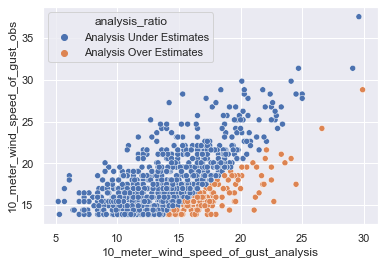

In [17]:
data['analysis_ratio'] = 'Equal'
ratio = data['10_meter_wind_speed_of_gust_obs'] / data['10_meter_wind_speed_of_gust_analysis']
data.loc[ratio > 1, 'analysis_ratio'] = 'Analysis Under Estimates'
data.loc[ratio < 1, 'analysis_ratio'] = 'Analysis Over Estimates'
del ratio
plot = sns.scatterplot(data=data, y='10_meter_wind_speed_of_gust_obs', x='10_meter_wind_speed_of_gust_analysis', hue='analysis_ratio')
print(data.groupby(['analysis_ratio']).analysis_ratio.count()/data.analysis_ratio.count())

### Filter data where analysis under estimates
Given that the analysis overwelmingly under-estimates the wind gust, only look those instances to produce as better regression

In [18]:
under_estimate = data[data.analysis_ratio == 'Analysis Under Estimates']
if os.path.exists('../data/derived/regressions.json'):
    regression = pd.read_json('../data/derived/regressions.json', orient='table')
    regression = pd.concat([regression, pd.DataFrame(dict(zip(['slope', 'intercept', 'rvalue', 'pvalue', 'stderr'], list(stats.linregress(under_estimate['10_meter_wind_speed_of_gust_analysis'], under_estimate['10_meter_wind_speed_of_gust_obs'])))), index=[siteID])]).reset_index().drop_duplicates(subset=['index'], keep='last').set_index('index')
    regression.index.name = None
else:
    regression = pd.DataFrame(dict(zip(['slope', 'intercept', 'rvalue', 'pvalue', 'stderr'], list(stats.linregress(under_estimate['10_meter_wind_speed_of_gust_analysis'], under_estimate['10_meter_wind_speed_of_gust_obs'])))), index=[siteID])
regression.to_json('../data/derived/regressions.json', orient='table')
regression

,slope,intercept,rvalue,pvalue,stderr
MTELV,0.893859,6.923222,0.703279,1.471382e-186,0.025618
LVM,1.022861,4.676071,0.796859,0.000000e+00,0.018798
MTLWM,0.894840,7.826072,0.683627,2.977567e-138,0.030286
6S0,0.796994,8.129035,0.685876,3.758471e-201,0.022276
1KM,0.715568,8.136230,0.735165,1.881445e-130,0.023934


### Plot Regression with data

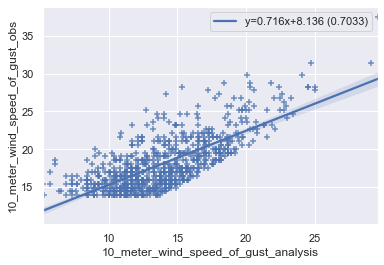

In [19]:
plot = sns.regplot(data=under_estimate, y='10_meter_wind_speed_of_gust_obs', x='10_meter_wind_speed_of_gust_analysis',marker='+', line_kws={'label':'y={0:.3f}x+{1:.3f} ({2:.4f})'.format(regression.slope[siteID], regression.intercept[siteID], regression.rvalue[0])})
legend = plot.legend()